In [4]:

from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow
!pip install -U spafe


import librosa                            # load audio
import IPython

# from spafe.features.gfcc import gfcc      # get GFCC coefs
# from spafe.utils import SlidingWindow
import numpy as np                        # concat , stack into 3d
from tqdm.notebook import tqdm            # progress


# dataframe building
import pandas as pd
import os                           # parse through files
from tqdm.notebook import tqdm      # get progress


# tensorflow
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 3.5 MB/s eta 0:00:00


# **Compute GFCCs**

In [5]:
# cepstrals.py

import numpy as np
from scipy.signal import lfilter
from typing_extensions import Literal

NormalizationType = Literal["mvn", "ms", "vn", "mn"]


def normalize_ceps(
  x: np.ndarray, normalization_type: NormalizationType = "mvn"
) -> np.ndarray:

  return {
      "mvn": (x - np.mean(x, axis=0)) / np.std(x),
      "ms": x - np.mean(x, axis=0),
      "vn": x / np.std(x),
      "mn": (x - np.mean(x)) / (np.max(x) - np.min(x)),
  }[normalization_type]


def lifter_ceps(ceps: np.ndarray, lift: int = 3) -> np.ndarray:

  if lift == 0 or lift > 10:
      return ceps

  elif lift > 0:
      lift_vec = np.array([1] + [i**lift for i in range(1, ceps.shape[1])])
      lift_mat = np.diag(lift_vec)
      return np.dot(ceps, lift_mat)

  else:
      lift = int(-1 * lift)
      lift_vec = 1 + (lift / 2.0) * np.sin(
          np.pi * np.arange(1, 1 + ceps.shape[1]) / lift
      )
      return ceps * lift_vec


def deltas(x: np.ndarray, w: int = 9) -> np.ndarray:

  _, cols = x.shape
  hlen = np.floor(w / 2)
  win = np.arange(hlen, -(hlen + 1), -1, dtype="float32")

  xx = np.append(
      np.append(np.tile(x[:, 0], (int(hlen), 1)).T, x, axis=1),
      np.tile(x[:, cols - 1], (int(hlen), 1)).T,
      axis=1,
  )

  deltas = lfilter(win, 1, xx, axis=1)[:, int(2 * hlen) : int(2 * hlen + cols)]
  return deltas

In [6]:
# converters.py

import numpy as np
from typing_extensions import Literal

# init vars
F0 = 0
FSP = 200 / 3
BARK_FREQ = 1000
BARK_PT = (BARK_FREQ - F0) / FSP
LOGSTEP = np.exp(np.log(6.4) / 27.0)
A = (1000 * np.log(10)) / (24.7 * 4.37)

ErbConversionApproach = Literal["Glasberg"]


def hz2erb(f: float, approach: ErbConversionApproach = "Glasberg") -> float:

  if approach == "Glasberg":
      return A * np.log10(1 + f * 0.00437)


def erb2hz(fe: float, approach: ErbConversionApproach = "Glasberg") -> float:

  if approach == "Glasberg":
      return (10 ** (fe / A) - 1) / 0.00437


BarkConversionApproach = Literal[
  "Wang", "Tjomov", "Schroeder", "Terhardt", "Zwicker", "Traunmueller"
]


def hz2bark(f: float, approach: BarkConversionApproach = "Wang") -> float:

  if approach == "Wang":
      return 6 * np.arcsinh(f / 600)
  elif approach == "Tjomov":
      return 6.7 * np.arcsinh((f + 20) / 600)
  elif approach == "Schroeder":
      return 7 * np.arcsinh(f / 650)
  elif approach == "Terhardt":
      return 13.3 * np.arctan((f * 0.75) / 1000)
  elif approach == "Zwicker":
      return 8.7 + 14.2 * np.log10(f / 1000)
  elif approach == "Traunmueller":
      return ((26.28 * f) / (1 + 1960)) - 0.53
  else:
      return 6 * np.arcsinh(f / 600)


def bark2hz(fb: float, approach: BarkConversionApproach = "Wang") -> float:

  if approach == "Wang":
      return 600 * np.sinh(fb / 6)
  elif approach == "Tjomov":
      return 600 * np.sinh(fb / 6.7) - 20
  elif approach == "Schroeder":
      return 650 * np.sinh(fb / 7)
  elif approach == "Terhardt":
      return (1000 / 0.75) * np.tan(fb / 13)
  elif approach == "Zwicker":
      return 10 ** (((fb - 8.7) / 14.2) + 3)
  elif approach == "Traunmueller":
      return 1960 * (
          (__traunmueller_helper(fb) + 0.53) / (26.28 - __traunmueller_helper(fb))
      )
  else:
      return 600 * np.sinh(fb / 6)


def __traunmueller_helper(fi: float) -> float:
  """
  Helper funtion for the Traunmueller approach.
  """
  if fi < 2:
      return (fi - 0.3) / (0.85)
  elif fi > 20.1:
      return (fi + 4.422) / 1.22
  else:
      return fi


MelConversionApproach = Literal["Oshaghnessy", "Lindsay"]


def hz2mel(f: float, approach: MelConversionApproach = "Oshaghnessy") -> float:

  return {
      "Oshaghnessy": 2595 * np.log10(1 + f / 700.0),
      "Lindsay": 2410 * np.log10(1 + f / 625),
  }[approach]


def mel2hz(fm: float, approach: MelConversionApproach = "Oshaghnessy") -> float:
  return {
      "Oshaghnessy": 700 * (10 ** (fm / 2595.0) - 1),
      "Lindsay": 625 * (10 ** (fm / 2410) - 1),
  }[approach]

In [7]:
# exceptions.py

ErrorMsgs = {
  "low_freq": "minimal frequency cannot be less than zero.",
  "high_freq": "maximum frequency cannot be greater than half sampling frequency.",
  "nfft": "size of the FFT must be an integer.",
  "nfilts": "number of filters must be bigger than number of cepstrums",
  "win_len_win_hop_comparison": "window's length has to be larger than the window's hop",
}


class SpafeError(Exception):
  """
  The root spafe exception class
  """


class ParameterError(SpafeError):
  """
  Exception class for mal-formed inputs
  """


def assert_function_availability(hasattr_output):
  # raise assertion error if function is not availible
  if not hasattr_output:
      raise AssertionError

In [8]:
# filters.py

import numpy as np
from scipy import signal
from typing_extensions import Literal

ScaleType = Literal["ascendant", "descendant", "constant"]


def rasta_filter(x: np.ndarray) -> np.ndarray:
  numer = np.arange(-2, 3)
  numer = (-1 * numer) / np.sum(numer**2)
  denom = np.array([1, -0.94])

  z = signal.lfilter_zi(numer, 1)
  y = np.zeros((x.shape))

  for i in range(x.shape[0]):
      # FIR for initial state response compuation
      y1, z = signal.lfilter(numer, 1, x[i, 0:4], axis=0, zi=z * x[i, 0])
      y1 = y1 * 0

      # IIR
      y2, _ = signal.lfilter(numer, denom, x[i, 4 : x.shape[1]], axis=0, zi=z)
      y[i, :] = np.append(y1, y2)
  return y


def scale_fbank(scale: ScaleType, nfilts: int) -> np.ndarray:
  return {
      "ascendant": np.array([i / nfilts for i in range(1, nfilts + 1)]).reshape(
          nfilts, 1
      ),
      "descendant": np.array([i / nfilts for i in range(nfilts, 0, -1)]).reshape(
          nfilts, 1
      ),
      "constant": np.ones(shape=(nfilts, 1)),
  }[scale]

In [9]:
"""

- Description : Preprocessing utils implementation.
- Copyright (c) 2019-2023 Ayoub Malek.
This source code is licensed under the terms of the BSD 3-Clause License.
For a copy, see <https://github.com/SuperKogito/spafe/blob/master/LICENSE>.

"""
from typing import Tuple

import numpy as np
from dataclasses import dataclass
from typing_extensions import Literal


WindowType = Literal["hanning", "bartlet", "kaiser", "blackman", "hamming"]


@dataclass
class SlidingWindow:

  win_len: float = 0.025
  win_hop: float = 0.010
  win_type: WindowType = "hamming"


def zero_handling(x: np.ndarray) -> np.ndarray:
  return np.where(x == 0, np.finfo(float).eps, x)


def pre_emphasis(sig: np.ndarray, pre_emph_coeff: float = 0.97) -> np.ndarray:
  return np.append(sig[0], sig[1:] - pre_emph_coeff * sig[:-1])


def stride_trick(a: np.ndarray, stride_length: int, stride_step: int) -> np.ndarray:
  a = np.array(a)
  nrows = ((a.size - stride_length) // stride_step) + 1
  n = a.strides[0]
  return np.lib.stride_tricks.as_strided(
      a, shape=(nrows, stride_length), strides=(stride_step * n, n)
  )


def framing(
  sig: np.ndarray, fs: int = 16000, win_len: float = 0.025, win_hop: float = 0.01
) -> Tuple[np.ndarray, int]:
  # run checks and assertions
  if win_len < win_hop:
      raise ParameterError(ErrorMsgs["win_len_win_hop_comparison"])

  # compute frame length and frame step (convert from seconds to samples)
  frame_length = int(win_len * fs)
  frame_step = int(win_hop * fs)

  # make sure to use integers as indices
  frames = stride_trick(sig, frame_length, frame_step)

  if len(frames[-1]) < frame_length:
      frames[-1] = np.append(
          frames[-1], np.array([0] * (frame_length - len(frames[0])))
      )

  return frames, frame_length

def windowing(
  frames: np.ndarray, frame_len: int, win_type: WindowType = "hamming"
) -> np.ndarray:
  return {
      "hanning": np.hanning(frame_len) * frames,
      "bartlet": np.bartlett(frame_len) * frames,
      "kaiser": np.kaiser(frame_len, beta=14) * frames,
      "blackman": np.blackman(frame_len) * frames,
      "hamming": np.hamming(frame_len) * frames,
  }[win_type]

In [10]:
# gammatone fbanks

from typing import Optional, Tuple

import numpy as np


# Slaney's ERB Filter constants
EarQ = 9.26449
minBW = 24.7


def generate_center_frequencies(
  min_freq: float, max_freq: float, nfilts: int
) -> np.ndarray:
  # init vars
  m = np.array(range(nfilts)) + 1
  c = EarQ * minBW

  # compute center frequencies
  center_freqs = (max_freq + c) * np.exp(
      (m / nfilts) * (np.log(min_freq + c) - np.log(max_freq + c))
  ) - c
  return center_freqs[::-1]


def compute_gain(
  fcs: np.ndarray, B: np.ndarray, wT: np.ndarray, T: float
) -> Tuple[np.ndarray, np.ndarray]:
  # pre-computations for simplification
  K = np.exp(B * T)
  Cos = np.cos(2 * fcs * np.pi * T)
  Sin = np.sin(2 * fcs * np.pi * T)
  Smax = np.sqrt(3 + 2 ** (3 / 2))
  Smin = np.sqrt(3 - 2 ** (3 / 2))

  # define A matrix rows
  A11 = (Cos + Smax * Sin) / K
  A12 = (Cos - Smax * Sin) / K
  A13 = (Cos + Smin * Sin) / K
  A14 = (Cos - Smin * Sin) / K

  # Compute gain (vectorized)
  A = np.array([A11, A12, A13, A14])
  Kj = np.exp(1j * wT)
  Kjmat = np.array([Kj, Kj, Kj, Kj]).T
  G = 2 * T * Kjmat * (A.T - Kjmat)
  Coe = -2 / K**2 - 2 * Kj**2 + 2 * (1 + Kj**2) / K
  Gain = np.abs(G[:, 0] * G[:, 1] * G[:, 2] * G[:, 3] * Coe**-4)
  return A, Gain


def gammatone_filter_banks(
  nfilts: int = 24,
  nfft: int = 512,
  fs: int = 16000,
  low_freq: float = 0,
  high_freq: Optional[float] = None,
  scale: ScaleType = "constant",
  order: int = 4,
  conversion_approach: ErbConversionApproach = "Glasberg",
):
  # init freqs
  high_freq = high_freq or fs / 2

  # run checks
  if low_freq < 0:
      raise ParameterError(ErrorMsgs["low_freq"])

  if high_freq > (fs / 2):
      raise ParameterError(ErrorMsgs["high_freq"])

  # define custom difference func
  def Dif(u, a):
      return u - a.reshape(nfilts, 1)

  # init vars
  fbank = np.zeros([nfilts, nfft])
  width = 1.0
  maxlen = nfft // 2 + 1
  T = 1 / fs
  n = 4
  u = np.exp(1j * 2 * np.pi * np.array(range(nfft // 2 + 1)) / nfft)
  idx = range(nfft // 2 + 1)

  # computer center frequencies, convert to ERB scale and compute bandwidths
  fcs = generate_center_frequencies(low_freq, high_freq, nfilts)
  ERB = width * ((fcs / EarQ) ** order + minBW**order) ** (1 / order)
  B = 1.019 * 2 * np.pi * ERB

  # compute input vars
  wT = 2 * fcs * np.pi * T
  pole = np.exp(1j * wT) / np.exp(B * T)

  # compute gain and A matrix
  A, Gain = compute_gain(fcs, B, wT, T)

  # compute fbank
  fbank[:, idx] = (
      (T**4 / Gain.reshape(nfilts, 1))
      * np.abs(Dif(u, A[0]) * Dif(u, A[1]) * Dif(u, A[2]) * Dif(u, A[3]))
      * np.abs(Dif(u, pole) * Dif(u, pole.conj())) ** (-n)
  )

  # make sure all filters has max value = 1.0
  try:
      fbank = np.array([f / np.max(f) for f in fbank[:, range(maxlen)]])

  except BaseException:
      fbank = fbank[:, idx]

  # compute scaling
  scaling = scale_fbank(scale=scale, nfilts=nfilts)
  fbank = fbank * scaling
  return fbank, np.array([hz2erb(freq, conversion_approach) for freq in fcs])

In [11]:
# Compute gfccs

from typing import Optional, Tuple

import numpy as np
from scipy.fftpack import dct




def erb_spectrogram(
  sig: np.ndarray,
  fs: int = 16000,
  pre_emph: bool = True,
  pre_emph_coeff: float = 0.97,
  window: Optional[SlidingWindow] = None,
  nfilts: int = 24,
  nfft: int = 512,
  low_freq: float = 0,
  high_freq: Optional[float] = None,
  scale: ScaleType = "constant",
  fbanks: Optional[np.ndarray] = None,
  conversion_approach: ErbConversionApproach = "Glasberg",
) -> Tuple[np.ndarray, np.ndarray]:

  # get fbanks
  if fbanks is None:
      # compute fbanks
      gamma_fbanks_mat, _ = gammatone_filter_banks(
          nfilts=nfilts,
          nfft=nfft,
          fs=fs,
          low_freq=low_freq,
          high_freq=high_freq,
          scale=scale,
          conversion_approach=conversion_approach,
      )
      fbanks = gamma_fbanks_mat

  # pre-emphasis
  if pre_emph:
      sig = pre_emphasis(sig=sig, pre_emph_coeff=0.97)

  # init window
  if window is None:
      window = SlidingWindow()

  # -> framing
  frames, frame_length = framing(
      sig=sig, fs=fs, win_len=window.win_len, win_hop=window.win_hop
  )

  # -> windowing
  windows = windowing(frames=frames, frame_len=frame_length, win_type=window.win_type)

  # -> FFT -> |.|
  ## Magnitude of the FFT
  fourrier_transform = np.absolute(np.fft.fft(windows, nfft))
  fourrier_transform = fourrier_transform[:, : int(nfft / 2) + 1]

  ## Power Spectrum
  abs_fft_values = (1.0 / nfft) * np.square(fourrier_transform)

  #  -> x Gammatone-fbanks
  features = np.dot(abs_fft_values, fbanks.T)
  return features, fourrier_transform


def gfcc(
  sig: np.ndarray,
  fs: int = 16000,
  num_ceps: int = 13,
  pre_emph: bool = True,
  pre_emph_coeff: float = 0.97,
  window: Optional[SlidingWindow] = None,
  nfilts: int = 24,
  nfft: int = 512,
  low_freq: float = 0,
  high_freq: Optional[float] = None,
  scale: ScaleType = "constant",
  dct_type: int = 2,
  use_energy: bool = False,
  lifter: Optional[int] = None,
  normalize: Optional[NormalizationType] = None,
  fbanks: Optional[np.ndarray] = None,
  conversion_approach: ErbConversionApproach = "Glasberg",
) -> np.ndarray:

  # run checks
  if nfilts < num_ceps:
      raise ParameterError(ErrorMsgs["nfilts"])

  # get features
  features, fourrier_transform = erb_spectrogram(
      sig=sig,
      fs=fs,
      pre_emph=pre_emph,
      pre_emph_coeff=pre_emph_coeff,
      window=window,
      nfilts=nfilts,
      nfft=nfft,
      low_freq=low_freq,
      high_freq=high_freq,
      scale=scale,
      conversion_approach=conversion_approach,
      fbanks=fbanks,
  )

  # compute the filter bank energies
  nonlin_rect_features = np.power(features, 1 / 3)
  gfccs = dct(x=nonlin_rect_features, type=dct_type, axis=1, norm="ortho")[
      :, :num_ceps
  ]

  # use energy for 1st features column
  if use_energy:
      # compute the # Magnitude of the FFT and then the Power Spectrum
      magnitude_frames = np.absolute(fourrier_transform)
      power_frames = (1.0 / nfft) * ((magnitude_frames) ** 2)

      # compute total energy in each frame
      frame_energies = np.sum(power_frames, 1)

      # Handling zero enegies
      energy = zero_handling(frame_energies)
      gfccs[:, 0] = np.log(energy)

  # liftering
  if lifter:
      gfccs = lifter_ceps(gfccs, lifter)

  # normalization
  if normalize:
      gfccs = normalize_ceps(gfccs, normalize)
  return gfccs

# **Trial to get GFCC**

In [12]:
import librosa

In [13]:
audio_path = '/content/drive/MyDrive/Alzheimers dementia classification/dataset/dementia-audio-classify/adrso_002_2_cn.wav'
waveform, sample_rate = librosa.load(audio_path)

gfccs = gfcc(waveform, fs=sample_rate, num_ceps=40, window=SlidingWindow(0.03, 0.025, "hamming"), nfilts=45)
gfccs.shape


# spafe.features.gfcc.gfcc(sig, fs=16000, num_ceps=13, pre_emph=0, pre_emph_coeff=0.97,
# win_len=0.025, win_hop=0.01, win_type='hamming', nfilts=26, nfft=512, low_freq=None, high_freq=None, scale='constant', dct_type=2, use_energy=False, lifter=22, normalize=1)

(800, 40)

> Changing hop length to reduce image size

## **Extract GFCC's**

In [47]:
def extract_3d_gfcc(audio_path):

    # get audio
    waveform, sample_rate = librosa.load(audio_path)

    # # play audio
    # IPython.display.Audio(data=waveform,rate = sample_rate)

    # extract mfcc
    # extarcting 40 for efficeint net
    gfccs = gfcc(sig = waveform,fs = sample_rate,num_ceps=40,window=SlidingWindow(0.02, 0.02, "hamming"),nfilts = 45)

    # extract delta mfcc
    delta_gfcc = librosa.feature.delta(gfccs,order=1)

    # extract delta-delta mfcc
    delta_delta_gfcc = librosa.feature.delta(gfccs,order=2)

    ## concatenate features along feature axis - along row - subject to change
    #gfcc_features = np.concatenate((gfccs,delta_gfcc,delta_delta_gfcc),axis = 0)

    # send three features
    gfcc_features = [gfccs,delta_gfcc,delta_delta_gfcc]

    return gfcc_features

# extract_3d_gfcc('/content/drive/MyDrive/Alzheimers dementia classification/dataset/dementia-audio-classify/adrso_002_2_cn.wav')

In [48]:
audio_path = '/content/drive/MyDrive/Alzheimers dementia classification/dataset/dementia-audio-classify/adrso_002_2_cn.wav'

# add gfcc's
gfcc_3d = extract_3d_gfcc(audio_path)

# stacked_gfcc
stacked_gfcc = np.stack( (gfcc_3d[0] , gfcc_3d[1] , gfcc_3d[2]),axis = -1 )

print(f'stacked_gfcc.shape = {stacked_gfcc.shape}')

stacked_gfcc.shape = (1000, 40, 3)


## **Build DataFrame**

In [49]:
# create data framesegment
data = pd.DataFrame(columns=['audio_path','subject','segment','gfcc','delta_gfcc','delta_delta_gfcc','stacked_gfcc','ad_or_not'])
data.info()

# dataframe cols
# path, subject ,segment , mfcc_3d, ad

dir_path = '/content/drive/MyDrive/Alzheimers dementia classification/dataset/dementia-audio-classify/'
files = os.listdir(dir_path)
count = 0

for file in tqdm(files):

    elems = []
    # 'audio_path','subject','segment','gfcc','delta_gfcc','delta_delta_gfcc','stacked_gfcc','ad_or_not'

    audio_path = os.path.join(dir_path,file)
    # audio_path
    elems.append(audio_path)

    parts = file.split('_')

    subject = parts[1]
    # subject
    elems.append(subject)

    segment = parts[2]
    # segment
    elems.append(segment)

    # add gfcc's
    gfcc_3d = extract_3d_gfcc(audio_path)

    # gfcc
    elems.append(gfcc_3d[0])

    # delta_gfcc
    elems.append(gfcc_3d[1])

    # delta_delta_gfcc
    elems.append(gfcc_3d[2])

    # stacked_gfcc
    stacked_gfcc = np.stack( (gfcc_3d[0] , gfcc_3d[1] , gfcc_3d[2]),axis = -1 )
    elems.append(stacked_gfcc)


    is_ad = parts[3].split('.')[0]
    if is_ad == 'ad':
        ad_or_not = 1
    elif is_ad == 'cn':
        ad_or_not = 0
    # ad_or_not
    elems.append(ad_or_not)

    elems_ragged = np.asarray(elems,dtype= 'object')

    # print(elems)

    # add to data frame
    leng = len(data)
    data.loc[leng] = elems_ragged

#     count += 1
#     if count%5 == 0:
#         print(count)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   audio_path        0 non-null      object
 1   subject           0 non-null      object
 2   segment           0 non-null      object
 3   gfcc              0 non-null      object
 4   delta_gfcc        0 non-null      object
 5   delta_delta_gfcc  0 non-null      object
 6   stacked_gfcc      0 non-null      object
 7   ad_or_not         0 non-null      object
dtypes: object(8)
memory usage: 0.0+ bytes


  0%|          | 0/486 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 485
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   audio_path        486 non-null    object
 1   subject           486 non-null    object
 2   segment           486 non-null    object
 3   gfcc              486 non-null    object
 4   delta_gfcc        486 non-null    object
 5   delta_delta_gfcc  486 non-null    object
 6   stacked_gfcc      486 non-null    object
 7   ad_or_not         486 non-null    object
dtypes: object(8)
memory usage: 34.2+ KB


In [ ]:
# we have 2003 window frames
# for each frame, we extract 20 ceps
# to maintain that temporal feature, first column shud be => ceps of first frame, sec col is => ceps of second window frame
# in the data we have, mfcc => first row is - ceps of first frame, sec row is - ceps of sec frame
# so we find the transpose
# then we stack

In [50]:
all_frames_ceps = data.loc[1,'gfcc']
each_frame_ceps = data.loc[1,'gfcc'][0]

print(f'Number of frames = {len(all_frames_ceps)}')
print(f'Number of ceps in each frame = {len(each_frame_ceps)}')
all_frames_ceps = data.loc[1,'stacked_gfcc'].shape
all_frames_ceps

Number of frames = 1000
Number of ceps in each frame = 40


(1000, 40, 3)

## **Visualize stacked array of gfcc's**

In [ ]:
# data_1 = data.copy()
# stcked_gfcc = data_1.loc[1,'stacked_gfcc']

# type(stcked_gfcc)

### **Split data into train and test 70:30**

In [51]:
# vertical stacking


labels = []
stcked_gfcc = []

for elem in range(len(data)):

    gfcc_stcked = data.loc[elem,'stacked_gfcc']

    # reshape (800, 120) to (800, 120, 1)
    # gfcc_stacked_reshaped = np.expand_dims(gfcc_stcked,axis = -1)  # -1 indicates choose appropriate position

    stcked_gfcc.append(gfcc_stcked)

    labels.append(data.loc[elem,'ad_or_not'])



    # gfcc_lyr_1 = np.transpose(data.loc[elem,'gfcc'])
    # gfcc_lyr_2 = np.transpose(data.loc[elem,'delta_gfcc'])
    # gfcc_lyr_3 = np.transpose(data.loc[elem,'delta_delta_gfcc'])
    # gfcc_stcked = np.stack((gfcc_lyr_1,gfcc_lyr_2,gfcc_lyr_3))
    # stcked_gfcc.append(gfcc_stcked)

print(f'Labels length = {len(labels)}')
print(f'GFCCs length = {len(stcked_gfcc)}\n')


print(f'shape(stcked_gfcc[0]) = {stcked_gfcc[0].shape}')
print(f'len(stcked_gfcc[0][0]) = {len(stcked_gfcc[0][0])}')


# convert to numpy array
stcked_gfcc = np.array(stcked_gfcc)
labels = np.array(labels)

labels = to_categorical(labels, num_classes=2)

Labels length = 486
GFCCs length = 486

shape(stcked_gfcc[0]) = (1000, 40, 3)
len(stcked_gfcc[0][0]) = 40


In [52]:

print(f'Max value in stacked_gfcc imaegs arrray = {np.max(stcked_gfcc)}')
print(f'Min value in stacked_gfcc imaegs arrray = {np.min(stcked_gfcc)}')

Max value in stacked_gfcc imaegs arrray = 3.4800956680978476
Min value in stacked_gfcc imaegs arrray = -4.167474483759809


In [ ]:
# stcked_gfcc = []
# labels = []
# for elem in range(len(data_1)):
#     gfcc_lyr_1 = np.transpose(data.loc[elem,'gfcc'])
#     gfcc_lyr_2 = np.transpose(data.loc[elem,'delta_gfcc'])
#     gfcc_lyr_3 = np.transpose(data.loc[elem,'delta_delta_gfcc'])
#     gfcc_stcked = np.stack((gfcc_lyr_1,gfcc_lyr_2,gfcc_lyr_3))
#     stcked_gfcc.append(gfcc_stcked)
#     labels.append(data.loc[elem,'ad_or_not'])

# print(f'Labels length = {len(labels)}')
# print(f'GFCCs length = {len(stcked_gfcc)}\n')


# print(f'shape(stcked_gfcc[0]) = {stcked_gfcc[0].shape}')
# print(f'len(stcked_gfcc[0][0]) = {len(stcked_gfcc[0][0])}')

In [53]:
from sklearn.model_selection import train_test_split


x_gfcc_train,x_gfcc_test,y_gfcc_train,y_gfcc_test = train_test_split(stcked_gfcc,labels,train_size = 0.7, random_state = 10)

### **Value distribution in train and test**

In [24]:
# Calculating the number of positive and negative classes in the training set
train_positive_count = np.sum(np.array(y_gfcc_train) == 1)
train_negative_count = np.sum(np.array(y_gfcc_train) == 0)

# Calculating the number of positive and negative classes in the testing set
test_positive_count = np.sum(np.array(y_gfcc_test) == 1)
test_negative_count = np.sum(np.array(y_gfcc_test) == 0)

# Displaying the label distribution
print("Training Set Label Distribution:")
print(f"Positive Count: {train_positive_count}")
print(f"Negative Count: {train_negative_count}")

print("\nTesting Set Label Distribution:")
print(f"Positive Count: {test_positive_count}")
print(f"Negative Count: {test_negative_count}")

(y_gfcc_train[0])

Training Set Label Distribution:
Positive Count: 340
Negative Count: 340

Testing Set Label Distribution:
Positive Count: 146
Negative Count: 146


array([0., 1.], dtype=float32)

### **Building model**

In [ ]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-io

In [ ]:
# keras.utils.plot_model(efficient_net_model, show_shapes=True)

In [54]:
# efficient_net_model.summary(line_length=110)

In [58]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [62]:
base_efficient_net_model = EfficientNetB0(weights = None,
                                     include_top = False,
                                     input_shape = (1000, 40 ,3),
                                     pooling = 'max',
                                     classes = 2,
                                     drop_connect_rate = 0.2)

x = base_efficient_net_model.output
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
x = Dense(16, activation = 'relu')(x)
x = Dense(8, activation = 'relu')(x)
predictions = Dense(2,  activation = 'softmax')(x)

model = Model(inputs = base_efficient_net_model.input, outputs = predictions)

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tensorflow.keras.backend.epsilon()
        y_pred = tensorflow.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = tensorflow.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        weight = tensorflow.pow(1 - y_pred, gamma)
        alpha_weight = alpha * y_true
        focal_loss = weight * alpha_weight * cross_entropy
        return tensorflow.reduce_sum(focal_loss, axis=-1)
    return loss


# Compile the model
model.compile(optimizer= 'adam', loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])

# Train the model and record loss
history = model.fit(x_gfcc_train, y_gfcc_train, epochs=10, validation_data=(x_gfcc_test, y_gfcc_test))



Epoch 1/10
11/11 [==============================] - 149s 10s/step - loss: 0.0744 - accuracy: 0.4588 - val_loss: 0.0433 - val_accuracy: 0.6370
Epoch 2/10
11/11 [==============================] - 105s 10s/step - loss: 0.0440 - accuracy: 0.5206 - val_loss: 0.0427 - val_accuracy: 0.6370
Epoch 3/10
11/11 [==============================] - 104s 10s/step - loss: 0.0431 - accuracy: 0.5412 - val_loss: 0.0423 - val_accuracy: 0.6370
Epoch 4/10
11/11 [==============================] - 104s 9s/step - loss: 0.0496 - accuracy: 0.5529 - val_loss: 0.0419 - val_accuracy: 0.6370
Epoch 5/10
11/11 [==============================] - 105s 10s/step - loss: 0.0439 - accuracy: 0.5824 - val_loss: 0.0416 - val_accuracy: 0.6370
Epoch 6/10
11/11 [==============================] - 104s 9s/step - loss: 0.0413 - accuracy: 0.6059 - val_loss: 0.0412 - val_accuracy: 0.6370
Epoch 7/10
11/11 [==============================] - 105s 10s/step - loss: 0.0401 - accuracy: 0.5912 - val_loss: 0.0405 - val_accuracy: 0.6370
Epoch 8/

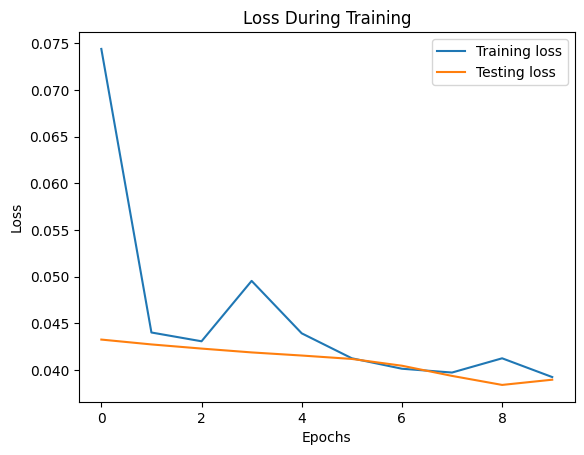

5/5 [==============================] - 14s 3s/step - loss: 0.0390 - accuracy: 0.6370
Test Loss: 0.038967013359069824
Test Accuracy:63.7%


In [63]:
import matplotlib.pyplot as plt

# plot loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss,label = 'Training loss')
plt.plot(test_loss,label = 'Testing loss')

plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_gfcc_test, y_gfcc_test)

# Print the metrics
print("Test Loss:", loss)
print(f"Test Accuracy:{round((accuracy * 100 ),2)}%")